In [32]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py

import numpy as np

# import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from himalaya.scoring import correlation_score
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from nilearn.glm.first_level import glover_hrf

from util import plot, subject, stats
from util.path import Path
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS, TR

from encoding import get_regressors

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
modelname = "joint"

features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding_t9"
cache = encmodel.split("_")[-1]
cache = 'trialmot9'

FG_MASK = get_brainmask()

modelname, encmodel, cache

('joint', 'encoding_t9', 'trialmot9')

In [ ]:
cachedir = f"results/cache/figureX-glm/{modelname}/{cache}/"
!mkdir -p $cachedir
cachedir

# test one subject

In [112]:
subA = 137
dataA = subject.get_bold(subA, cache=cache)
# prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)
dataA.shape

(1200, 81924)

In [113]:
regressors = get_regressors(subA, 'model-gpt2-2b_layer-24', split=True)

kernel = glover_hrf(TR, oversampling=1, time_length=20)

regressor = regressors['prod_word_onset'].ravel()
regressor = np.convolve(regressor, kernel)[:len(regressor)]
prod_model = LinearRegression().fit(regressor.reshape(-1, 1), dataA)

regressor = regressors['comp_word_onset'].ravel()
regressor = np.convolve(regressor, kernel)[:len(regressor)]
comp_model = LinearRegression().fit(regressor.reshape(-1, 1), dataA)

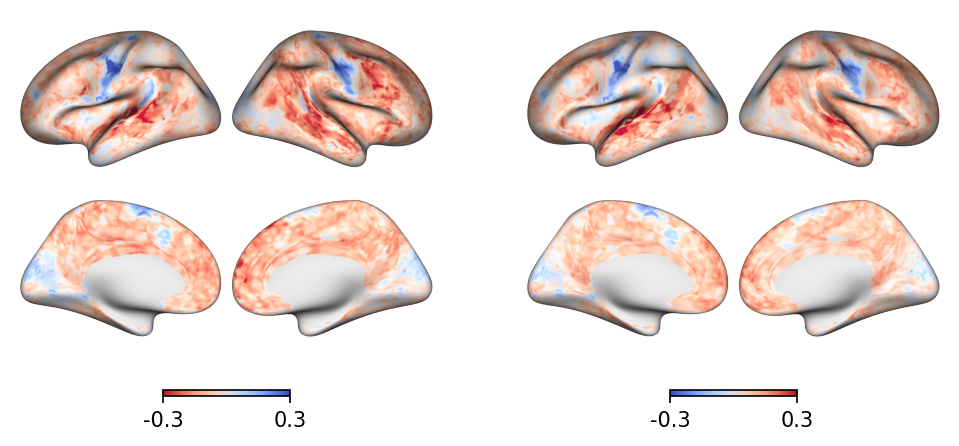

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot.surface_plot(prod_model.coef_.ravel(), fig=fig, ax=axes[0], inflation=200, cmap='coolwarm_r')
plot.surface_plot(comp_model.coef_.ravel(), fig=fig, ax=axes[1], inflation=200)
fig.show()

# group level

In [89]:
kernel = glover_hrf(TR, oversampling=1, time_length=20)

prod_coefs = []
comp_coefs = []

for subA in tqdm(SUBS_STRANGERS):
    dataA = subject.get_bold(subA, cache=cache)
    regressors = get_regressors(subA, 'model-gpt2-2b_layer-24', split=True)

    regressor = regressors['prod_word_onset'].ravel()
    regressor = np.convolve(regressor, kernel)[:len(regressor)]
    prod_model = LinearRegression().fit(regressor.reshape(-1, 1), dataA)

    regressor = regressors['comp_word_onset'].ravel()
    regressor = np.convolve(regressor, kernel)[:len(regressor)]
    comp_model = LinearRegression().fit(regressor.reshape(-1, 1), dataA)

    prod_coefs.append(prod_model.coef_)
    comp_coefs.append(comp_model.coef_)

prod_coefs = np.stack(prod_coefs)
comp_coefs = np.stack(comp_coefs)
prod_coefs.shape

100%|██████████| 58/58 [05:59<00:00,  6.20s/it]


(58, 81924, 1)

In [90]:
pcoefs = prod_coefs.mean(0).squeeze()
ccoefs = comp_coefs.mean(0).squeeze()

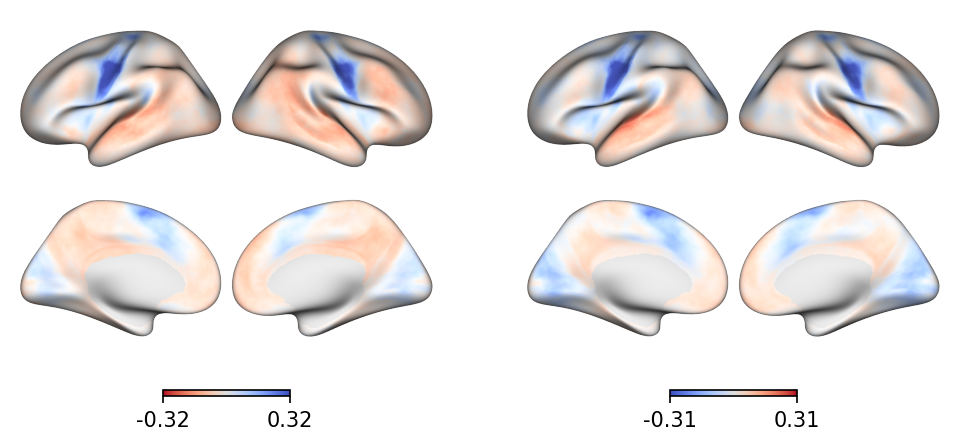

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot.surface_plot(pcoefs, fig=fig, ax=axes[0], inflation=200, cmap='coolwarm_r')
plot.surface_plot(ccoefs, fig=fig, ax=axes[1], inflation=200)
fig.show()